# Begining

* [Makersuite](https://makersuite.google.com/waitlist)

* [Dcoumentation](https://developers.generativeai.google/api)

* [Palm 2 intro](https://www.youtube.com/watch?v=yAANQypgOo8)

* [Med Palm 2](https://www.youtube.com/watch?v=k_-Z_TkHMqA)

# Stanford Alpaca: An Instruction-following LLaMA Model

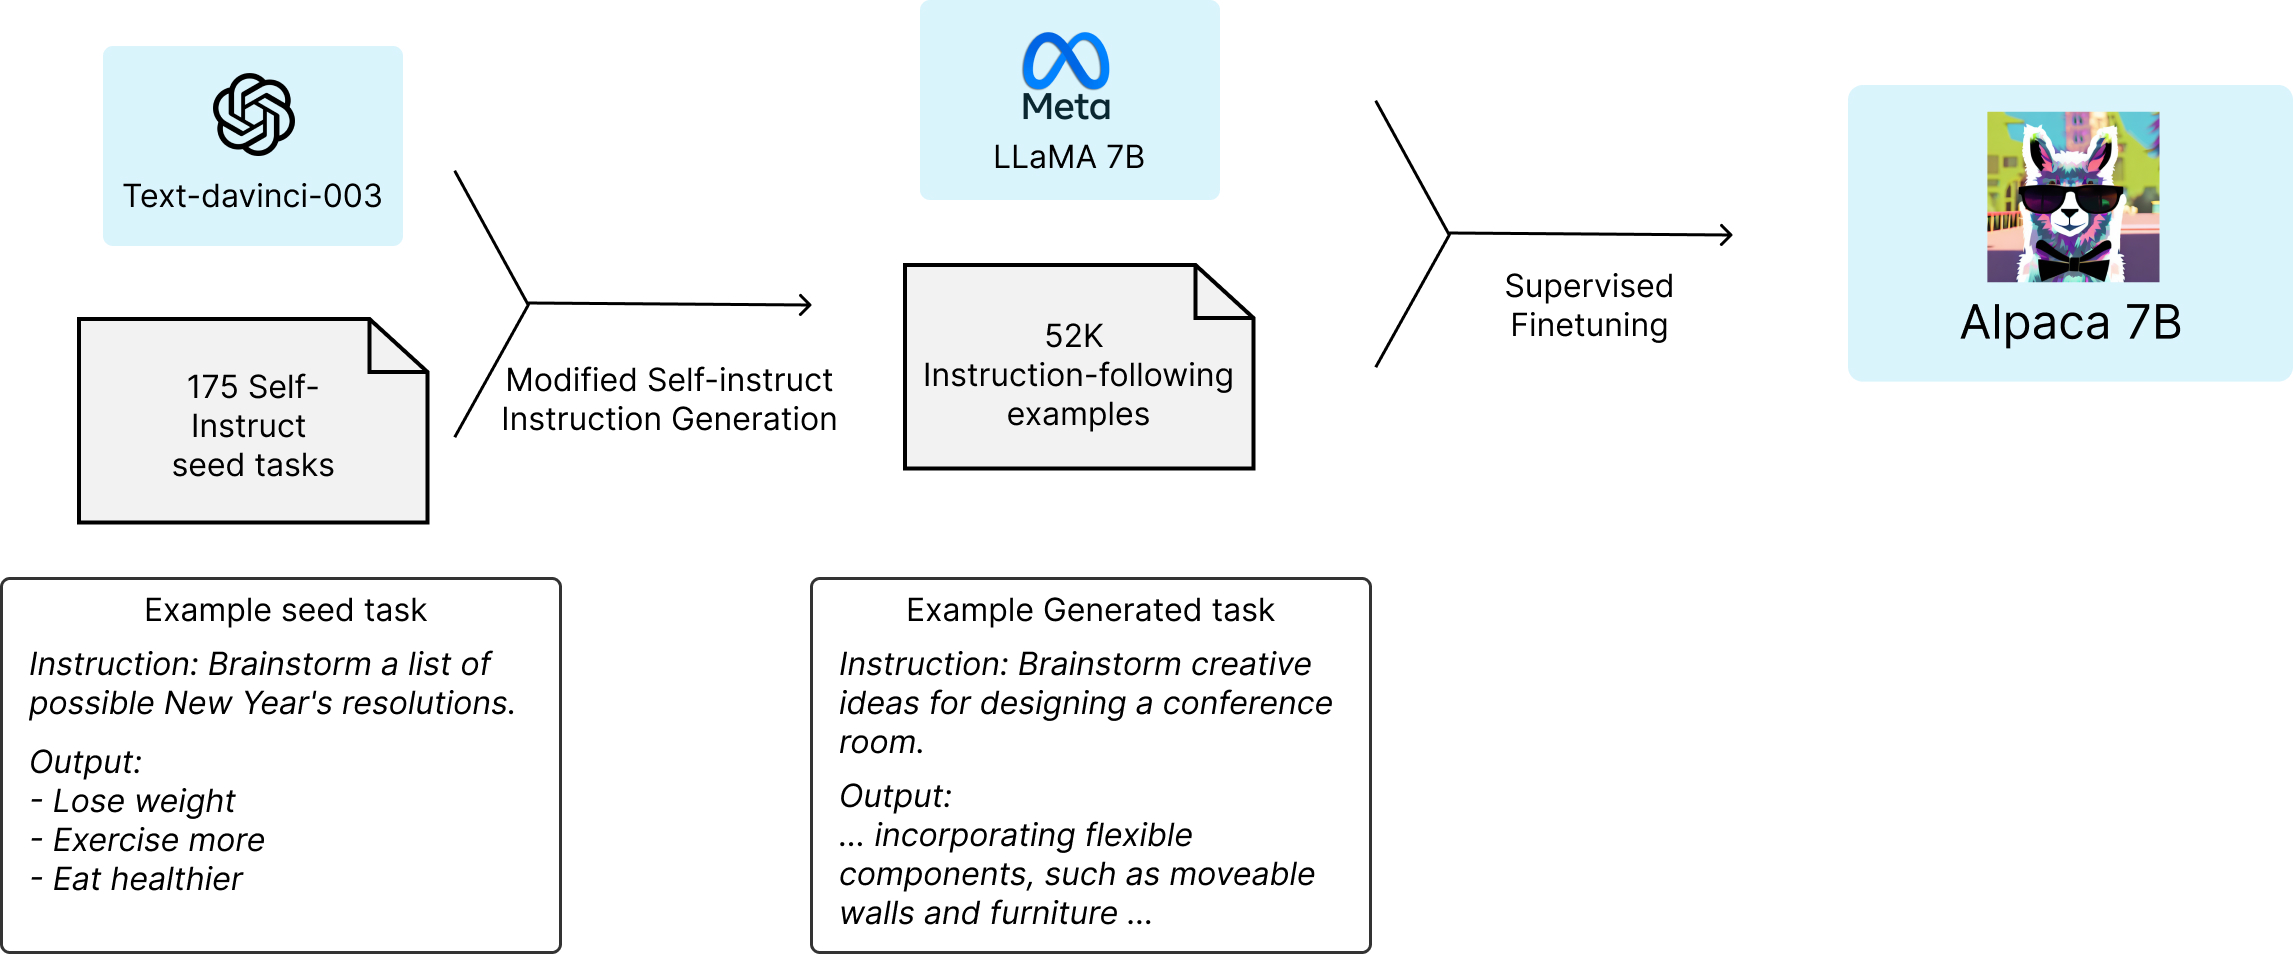

The repository of Alpaca LoRa1 provides code for reproducing the Stanford Alpaca results using low-rank adaptation (LoRA). Included is an Instruct model similar in quality to text-davinci-003. The code can be extended to the 13b, 30b, and 65b models, and Hugging Face's PEFT2 and Tim Dettmers' bitsandbytes3 are used for efficient and inexpensive fine-tuning.

In [ ]:
!pip install -U pip
!pip install accelerate==0.20.3
!pip install appdirs==1.4.4
!pip install bitsandbytes==0.37.2
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for accelerate==0.20.3 from https://files.pythonhosted.org/packages/10/d3/5382aa337d3e67214003a17b06bfc07cf0334356b4e8aaf3b12b0d38c83f/accelerate-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5

In [ ]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-3lf5

'cuda'

In [ ]:
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN

Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/alpaca-lora/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 88.3MB/s]


In [ ]:
df = pd.read_csv("bitcoin-sentiment-tweets.csv")
df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


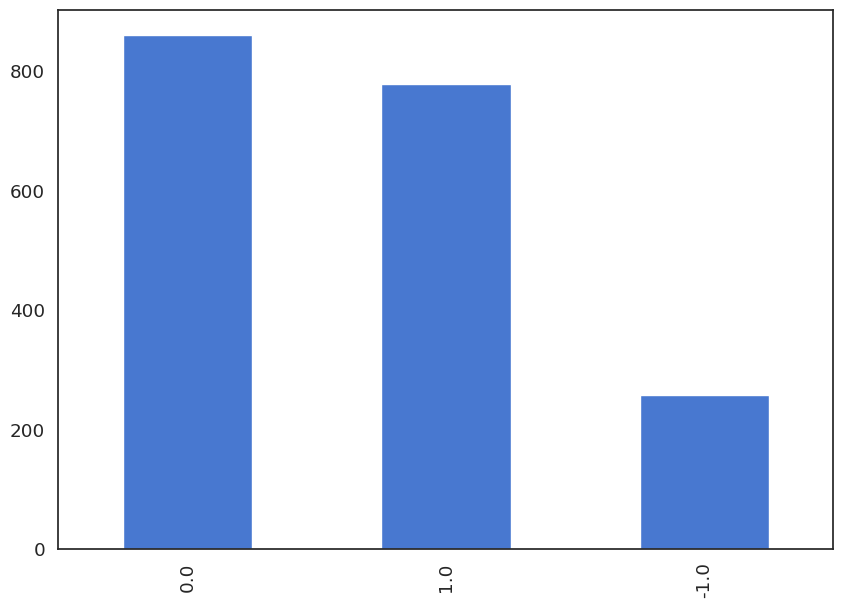

In [ ]:
df.sentiment.value_counts().plot(kind='bar');

In [ ]:
def sentiment_score_to_name(score: float):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    return "Neutral"

dataset_data = [
    {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row_dict["tweet"],
        "output": sentiment_score_to_name(row_dict["sentiment"])
    }
    for row_dict in df.to_dict(orient="records")
]

dataset_data[0]

In [ ]:
import json
with open("alpaca-bitcoin-sentiment-dataset.json", "w") as f:
   json.dump(dataset_data, f)

# Modle Weights

In [ ]:
BASE_MODEL = "decapoda-research/llama-7b-hf"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


# DataSet

In [ ]:
data = load_dataset("json", data_files="alpaca-bitcoin-sentiment-dataset.json")
data["train"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-996e073157c21ca1/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 1897
})

In [ ]:
def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""


def tokenize(prompt, add_eos_token=True):
    CUTOFF_LEN=800
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

The first function generate_prompt takes a data point from the dataset and generates a prompt by combining the instruction, input, and output values. The second function tokenize takes the generated prompt and tokenizes it using the tokenizer defined earlier. It also adds an end-of-sequence token to the input sequence and sets the label to be the same as the input sequence. The third function generate_and_tokenize_prompt combines the first two functions to generate and tokenize the prompt in one step.

In [ ]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

# Training

In [ ]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [ ]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


We initialize and prepare the model for training with the LORA algorithm, which is a form of quantization that can reduce model size and memory usage without significant loss in accuracy.

LoraConfig7 is a class that specifies the hyperparameters for the LORA algorithm, such as the regularization strength (lora_alpha), the dropout probability (lora_dropout), and the target modules to be compressed (target_modules).

In [ ]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

This code creates a TrainingArguments object which specifies various settings and hyperparameters for training the model. These include:

* gradient_accumulation_steps: Number of updates steps to accumulate gradients before performing a backward/update pass.
warmup_steps: Number of warmup steps for the optimizer.
* max_steps: The total number of training steps to perform.
* learning_rate: The learning rate for the optimizer.
* fp16: Use 16-bit precision for training.

In [ ]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

DataCollatorForSeq2Seq is a class from the Transformers library that creates batches of input/output sequences for sequence-to-sequence (seq2seq) models. In this code, a DataCollatorForSeq2Seq object is instantiated with the following parameters:

* pad_to_multiple_of: An integer representing the maximum sequence length, rounded up to the nearest multiple of this value.
* padding: A boolean indicating whether to pad the sequences to the specified maximum length.

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))

model = torch.compile(model)

trainer.train()
model.save_pretrained(OUTPUT_DIR)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

# Deploy on Hugging Face

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

model.push_to_hub("curiousily/alpaca-bitcoin-tweets-sentiment", use_auth_token=True)

In [ ]:
!git clone https://github.com/tloen/alpaca-lora.git
%cd alpaca-lora
!git checkout a48d947

Cloning into 'alpaca-lora'...
remote: Enumerating objects: 607, done.
remote: Total 607 (delta 0), reused 0 (delta 0), pack-reused 607
Receiving objects: 100% (607/607), 27.84 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (358/358), done.
/content/alpaca-lora
Note: switching to 'a48d947'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a48d947 把中文LoRA放在一起


In [ ]:
!python generate.py \
    --load_8bit \
    --base_model 'decapoda-research/llama-7b-hf' \
    --lora_weights 'curiousily/alpaca-bitcoin-tweets-sentiment' \
    --share_gradio

2023-07-27 13:52:47.690135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28